# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance

## import dependencies

In [47]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime


## Read File

In [3]:
file_to_open = os.path.join('Resources/BTCUSDT=BNNC.csv')
BTC_data_complete_df = pd.read_csv(file_to_open)
BTC_data_complete_df.shape

(17439, 11)

In [4]:
# 10 sample rows
BTC_data_complete_df.sample(10)

,Date (GMT),Open,High,Low,Last,Volume,MACD,MACD Signal Line,BBandUp,BBandMid,BBandLow
8112,4/18/2021 8:30,56132.38,56498.00,55659.47,56198.30,2559.2360,-1180.629118,-1191.550460,61214.00803,57228.48017,53242.95231
12293,7/15/2021 9:30,32376.50,32620.31,32332.54,32501.09,1060.3261,-76.524554,-45.235929,32939.55216,32592.89156,32246.23096
14315,8/26/2021 18:00,46969.69,47032.64,46891.25,46952.77,482.9296,-211.474248,-258.705573,47442.19323,47067.32856,46692.46389
7859,4/13/2021 2:00,60270.62,60780.26,60270.61,60637.69,2117.6550,68.081301,-2.353381,60614.63774,60135.76755,59656.89737
3578,1/13/2021 17:00,34459.10,34785.00,34388.53,34785.00,993.0511,148.627850,148.592827,34996.70309,34455.03566,33913.36823
9087,5/8/2021 22:00,58830.51,59098.99,58735.00,58794.29,945.4420,176.129039,194.699777,59575.79329,58791.65158,58007.50988
9970,5/28/2021 0:00,38418.00,38643.84,38279.10,38508.59,1001.9555,-131.003646,-59.699319,39907.77907,38856.51706,37805.25505
15195,9/14/2021 2:00,45240.69,45290.00,45101.68,45128.87,446.9970,106.455312,65.878087,45509.82100,44915.73191,44321.64282
5636,2/25/2021 16:30,50828.18,51370.18,50563.82,51081.80,1763.4895,315.479135,241.791031,52132.72722,50517.78137,48902.83552
6723,3/20/2021 10:00,58712.10,58899.00,58577.55,58780.03,966.8295,43.274206,-8.531813,58914.74646,58508.16654,58101.58661


## code machine larning: Linear regresion

In [5]:
# showing only BTC price
BTC_data_price_df = BTC_data_complete_df[['Last']]
BTC_data_price_df.head(14)

#consider changing last to price, i,e, last=price

,Last
0,13553.09
1,13615.57
2,13560.10
3,13557.98
4,13615.06
5,13591.36
6,13636.14
7,13687.31
8,13611.71
9,13481.87


In [6]:
BTC_data_price_df.tail(14)

,Last
17425,61277.78
17426,61256.42
17427,61359.91
17428,61410.63
17429,61454.42
17430,61560.92
17431,61499.99
17432,61725.56
17433,61943.96
17434,61642.12


In [7]:
#  variable for predicting x number of days into the future
predict_days = 14 #numer of days, then change this info to function

# create another column shifted n units up
BTC_data_price_df['Prediction'] = BTC_data_price_df[['Last']].shift(-predict_days)

<ipython-input-7-38f198fed041>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_data_price_df['Prediction'] = BTC_data_price_df[['Last']].shift(-predict_days)


In [8]:
# show df with new column
BTC_data_price_df.head(14)

,Last,Prediction
0,13553.09,13473.27
1,13615.57,13528.49
2,13560.10,13612.04
3,13557.98,13562.91
4,13615.06,13576.14
5,13591.36,13818.01
6,13636.14,13739.95
7,13687.31,13740.65
8,13611.71,13893.22
9,13481.87,13754.99


In [9]:
# show last 5 rows of new dataset
BTC_data_price_df.tail(15)

,Last,Prediction
17424,61384.08,61584.51
17425,61277.78,NaN
17426,61256.42,NaN
17427,61359.91,NaN
17428,61410.63,NaN
17429,61454.42,NaN
17430,61560.92,NaN
17431,61499.99,NaN
17432,61725.56,NaN
17433,61943.96,NaN


In [10]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(BTC_data_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_days]
print(a)

[[13553.09]
 [13615.57]
 [13560.1 ]
 ...
 [61180.87]
 [61302.12]
 [61384.08]]


In [11]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = BTC_data_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_days]
print(b)

[13473.27 13528.49 13612.04 ... 61440.   61386.59 61584.51]


In [12]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [13]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

In [14]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.9833544615908769


In [15]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(BTC_data_price_df[['Last']])[-predict_days:]
print(a_projection)

[[61277.78]
 [61256.42]
 [61359.91]
 [61410.63]
 [61454.42]
 [61560.92]
 [61499.99]
 [61725.56]
 [61943.96]
 [61642.12]
 [61525.43]
 [61440.  ]
 [61386.59]
 [61584.51]]


In [16]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[61224.03491417 61202.76232161 61305.82882928 61356.34127753
 61399.95208409 61506.01627452 61445.3356067  61669.98254975
 61887.48883322 61586.8839953  61470.67150346 61385.5910923
 61332.39965182 61529.50974168]


In [17]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual price', 'predicted price'])
results_df

,actual price,predicted price
0,[61277.78],61224.034914
1,[61256.42],61202.762322
2,[61359.91],61305.828829
3,[61410.63],61356.341278
4,[61454.42],61399.952084
5,[61560.92],61506.016275
6,[61499.99],61445.335607
7,[61725.56],61669.982550
8,[61943.96],61887.488833
9,[61642.12],61586.883995


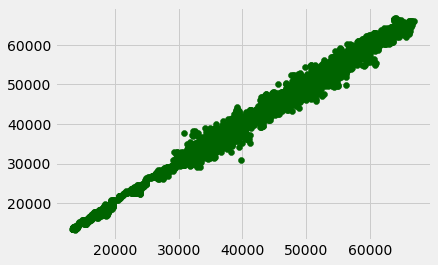

In [18]:
plt.scatter(a, b, color="DarkGreen" )

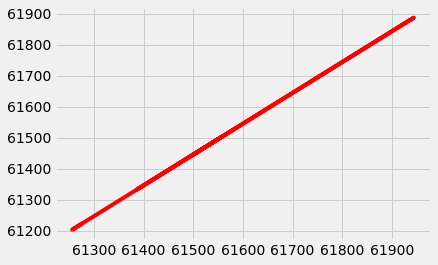

In [19]:
plt.plot(a_projection,Lreg_predict, color='r')

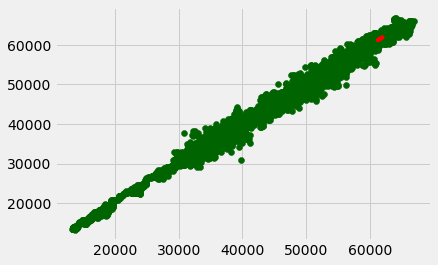

In [20]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## MACD

## BOLLINGER BANDS

In [99]:
# from the complete data, set index to date
BTC_data_complete_df = BTC_data_complete_df.\
set_index(pd.DatetimeIndex(BTC_data_complete_df['Date (GMT)'].values))
BTC_data_complete_df.head(10)

,Date (GMT),Open,High,Low,Last,Volume,MACD,MACD Signal Line,BBandUp,BBandMid,BBandLow
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531,NaN,NaN,NaN,NaN,NaN
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268,NaN,NaN,NaN,NaN,NaN
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061,NaN,NaN,NaN,NaN,NaN
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756,NaN,NaN,NaN,NaN,NaN
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320,NaN,NaN,NaN,NaN,NaN
2020-10-31 01:30:00,10/31/2020 1:30,13615.05,13657.16,13588.78,13591.36,861.6386,NaN,NaN,NaN,NaN,NaN
2020-10-31 02:00:00,10/31/2020 2:00,13591.35,13643.62,13571.30,13636.14,568.5373,NaN,NaN,NaN,NaN,NaN
2020-10-31 02:30:00,10/31/2020 2:30,13636.15,13740.00,13635.27,13687.31,1791.1294,NaN,NaN,NaN,NaN,NaN
2020-10-31 03:00:00,10/31/2020 3:00,13685.78,13717.05,13559.74,13611.71,1222.3967,NaN,NaN,NaN,NaN,NaN
2020-10-31 03:30:00,10/31/2020 3:30,13611.72,13621.95,13411.50,13481.87,2179.7335,NaN,NaN,NaN,NaN,NaN


In [22]:
#creating bollinger band dataframe
BTC_BB_df1= BTC_data_complete_df.loc[:,:'Volume']
BTC_BB_df1.head()

,Date (GMT),Open,High,Low,Last,Volume
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320


In [23]:
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
BTC_BB_df1['SMA']=BTC_BB_df1['Last'].rolling(window = period).mean()
#calculate std
BTC_BB_df1['STD']=BTC_BB_df1['Last'].rolling(window = period).std()
#calculate BB UP
BTC_BB_df1['BBand Upper']=BTC_BB_df1['SMA']+(BTC_BB_df1['STD']*2)
#calculate BB LOW
BTC_BB_df1['BBand Lower']=BTC_BB_df1['SMA']-(BTC_BB_df1['STD']*2)

BTC_BB_df1.head()

,Date (GMT),Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531,NaN,NaN,NaN,NaN
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268,NaN,NaN,NaN,NaN
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061,NaN,NaN,NaN,NaN
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756,NaN,NaN,NaN,NaN
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320,NaN,NaN,NaN,NaN


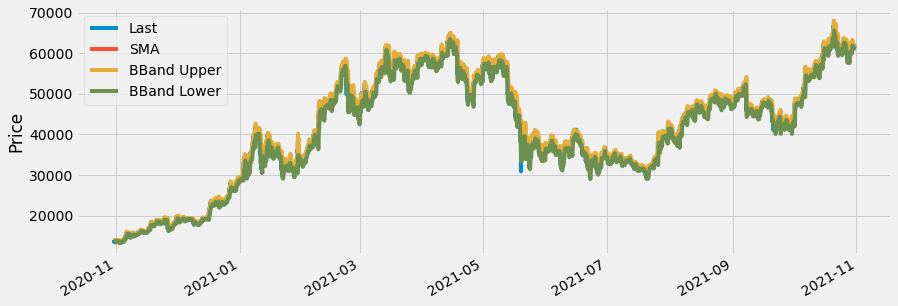

In [66]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
BTC_BB_df1[column_ls].plot(figsize=(13,5))

plt.ylabel('Price')
plt.show()

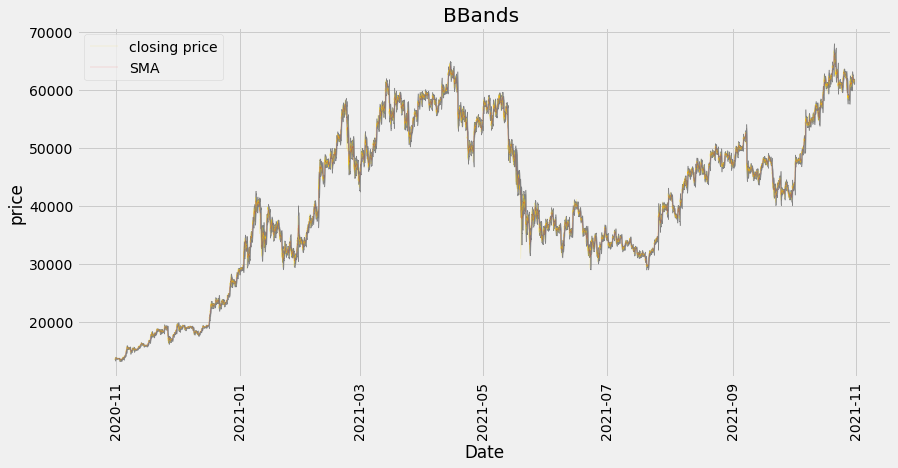

In [67]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
fig = plt.figure(figsize = (13,6))
ax=fig.add_subplot(1,1,1)
x_axis=BTC_BB_df1.index
ax.fill_between(x_axis,BTC_BB_df1['BBand Upper'], BTC_BB_df1['BBand Lower'], color='grey')
ax.plot(x_axis,BTC_BB_df1['Last'], color = 'gold', label='closing price', linewidth=0.1)
ax.plot(x_axis,BTC_BB_df1['SMA'], color = 'red', label='SMA', linewidth=0.1)
ax.set_title('BBands ')
ax.set_xlabel('Date')
ax.set_ylabel('price')
plt.xticks(rotation = 90)
ax.legend()
plt.show()


In [26]:
# FILTER BY DATE
date = datetime(2021,10,18)
BTC_BB_ZOOM_df = BTC_BB_df1[BTC_BB_df1.index > date]
BTC_BB_ZOOM_df.head(10)

,Date (GMT),Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
2021-10-18 00:30:00,10/18/2021 0:30,61528.32,62000.00,61406.27,61942.96,1213.6225,60799.3375,614.915055,62029.167611,59569.507389
2021-10-18 01:00:00,10/18/2021 1:00,61942.39,62471.53,61942.39,62466.92,2318.0146,60871.6335,718.604381,62308.842262,59434.424738
2021-10-18 01:30:00,10/18/2021 1:30,62466.92,62578.91,62228.02,62351.99,1445.6212,60948.1280,790.849860,62529.827719,59366.428281
2021-10-18 02:00:00,10/18/2021 2:00,62352.00,62426.54,62000.00,62096.65,857.8021,61015.0195,829.622689,62674.264878,59355.774122
2021-10-18 02:30:00,10/18/2021 2:30,62097.66,62329.34,61942.40,62083.94,716.1911,61073.4195,862.730226,62798.879951,59347.959049
2021-10-18 03:00:00,10/18/2021 3:00,62083.94,62252.95,62007.17,62106.22,638.9362,61130.2445,892.456901,62915.158302,59345.330698
2021-10-18 03:30:00,10/18/2021 3:30,62106.22,62271.34,62085.00,62137.69,499.1663,61188.2780,919.302311,63026.882621,59349.673379
2021-10-18 04:00:00,10/18/2021 4:00,62137.70,62187.90,61881.00,62123.88,532.3081,61242.9890,941.654300,63126.297600,59359.680400
2021-10-18 04:30:00,10/18/2021 4:30,62123.88,62180.00,62000.01,62085.47,482.5262,61298.2255,957.725427,63213.676353,59382.774647
2021-10-18 05:00:00,10/18/2021 5:00,62085.46,62419.99,62015.00,62381.80,814.5705,61368.6650,983.994437,63336.653873,59400.676127


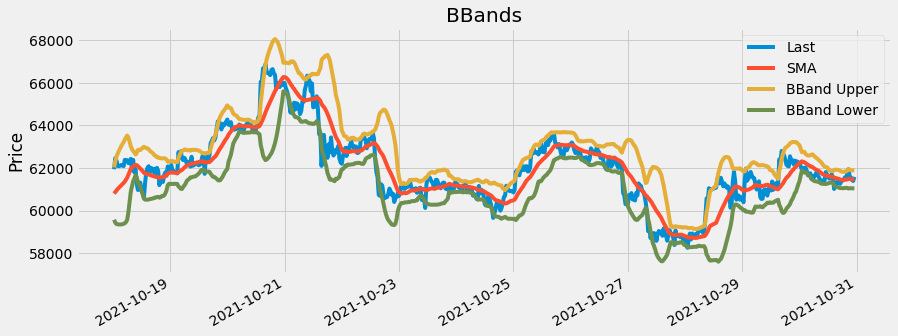

In [27]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
BTC_BB_ZOOM_df[column_ls].plot(figsize=(13,5))
plt.title('BBands')
plt.ylabel('Price')             
plt.show()

In [32]:
#create a new data frame
new_df = BTC_BB_df1[period:-1]
new_df.shape

(17418, 10)

In [97]:
# create function to buy and sell signals
def alert_signal(data):
    maintain_s = []
    maintain_date = []
    
    buy_date = []
    buy_s = []
    
    buy_graph_s = []
    
    sell_date = []
    sell_s = []
    
    sell_graph_s = []
    
    for i in range(len(data['Last'])):
        if data['Last'][i] > data['BBand Upper'][i]:
#             buy_date.append(data['Date (GMT)'][i])
            buy_s.append(True)
    
#             buy_graph_s.append(np.nan)
            
        elif data['Last'][i] < data['BBand Lower'][i]:
#             sell_date.append(data['Date (GMT)'][i])
            sell_s.append(True)
#             sell_graph_s.append(np.nan)
        else:
            maintain_s.append('1')
#             maintain_date.append(data['Date (GMT)'][i])

        results = zip( BTC_BB_df1['Date (GMT)'] ,
        maintain_s ,
        buy_s ,
        sell_s )
        resultsdf= pd.DataFrame(results, columns = ['Date', 
                                                    'maintain signal', 
                                                    'buy signal','sell signal']) 
    return (resultsdf.head(20))

In [98]:
alert_signal(new_df)

,Date,maintain signal,buy signal,sell signal
0,10/30/2020 23:00,1,True,True
1,10/30/2020 23:30,1,True,True
2,10/31/2020 0:00,1,True,True
3,10/31/2020 0:30,1,True,True
4,10/31/2020 1:00,1,True,True
5,10/31/2020 1:30,1,True,True
6,10/31/2020 2:00,1,True,True
7,10/31/2020 2:30,1,True,True
8,10/31/2020 3:00,1,True,True
9,10/31/2020 3:30,1,True,True


## Machine learning